### Get all time related vectors from BehaviorSync and create some basic comparisons

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()


Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [2]:
import u19_pipeline.ephys_pipeline as ep
import u19_pipeline.recording as recording
import matplotlib.pyplot as plt
import datajoint as dj
 


[2026-02-18 17:28:10,328][INFO]: DataJoint 0.14.4 connected to alvaros@datajoint00.pni.princeton.edu:3306


#### Select recording_id to fetch from

In [44]:
recording_key = dict()
recording_key['recording_id'] = 362

#### Get behaviorSync and behavior records:

In [45]:

sync_record = (ep.BehaviorSync & recording_key).fetch1('sync_data')

behavior = dj.create_virtual_module('behavior','u19_behavior')
behavior_session = (recording.Recording.BehaviorSession & recording_key).fetch(as_dict=True)[0]
behavior_session.pop('recording_id')
behavior_time = (behavior.SpatialTimeBlobs & behavior_session).fetch(as_dict=True)

behavior_session

{'subject_fullname': 'ms81_M029',
 'session_date': datetime.date(2024, 8, 29),
 'session_number': 0}

#### Fetch all time & idx related vectors (check ephys_pipeline function for all descriptions)

In [46]:
all_vectors = ep.get_full_vectors_from_key(recording_key)

ephys dir: /mnt/cup/braininit/Data/Raw/electrophysiology/ms81/ms81_M029/20240829_g0/towerstask_g0


In [47]:
all_vectors.keys()

dict_keys(['trial_index_nidq_virmen', 'iteration_index_nidq_virmen', 'trial_index_nidq', 'iteration_index_nidq', 'time_vector', 'time_as_behavior_trial_ind', 'time_as_behavior_fullsession', 'time_as_behavior_trial_ind_virmen', 'time_as_behavior_fullsession_virmen'])

In [48]:
all_vectors['time_as_behavior_fullsession'].shape

(272,)

#### Concatenate arrays of arrays vectors to get single vector time variables

In [49]:
import numpy as np
time_as_behavior_fullsession = np.concatenate(([x for x in all_vectors['time_as_behavior_fullsession']]), axis=0) 
time_as_behavior_trial_ind = np.concatenate(([x for x in all_vectors['time_as_behavior_trial_ind']]), axis=0) 

time_as_behavior_fullsession_v = np.concatenate(([x for x in all_vectors['time_as_behavior_fullsession_virmen']]), axis=0) 
time_as_behavior_trial_ind_v = np.concatenate(([x for x in all_vectors['time_as_behavior_trial_ind_virmen']]), axis=0) 



#### Compare behvaior file time variables vs BehaviorSync ones 

In [50]:
diff_time_trial_ind = time_as_behavior_trial_ind - behavior_time[0]['trial_time'].squeeze()
diff_time_trial_ind_v = time_as_behavior_trial_ind_v- behavior_time[0]['trial_time'].squeeze()

diff_time_trial_full_session = time_as_behavior_fullsession - (behavior_time[0]['cumulative_session_time'].squeeze() - behavior_time[0]['cumulative_session_time'][0])
diff_time_trial_full_session_v = time_as_behavior_fullsession_v - (behavior_time[0]['cumulative_session_time'].squeeze() - behavior_time[0]['cumulative_session_time'][0])


#### "pulse only sync" Each trial individual time [0, ...] x ntrials 
#### Compare  iteration "start time" --- nidaq pulse signal vs behavior file

Text(0.5, 1.0, 'iteration "start time" comparison -- behavior file - nidaq pulse signal. Each trial ind. time')

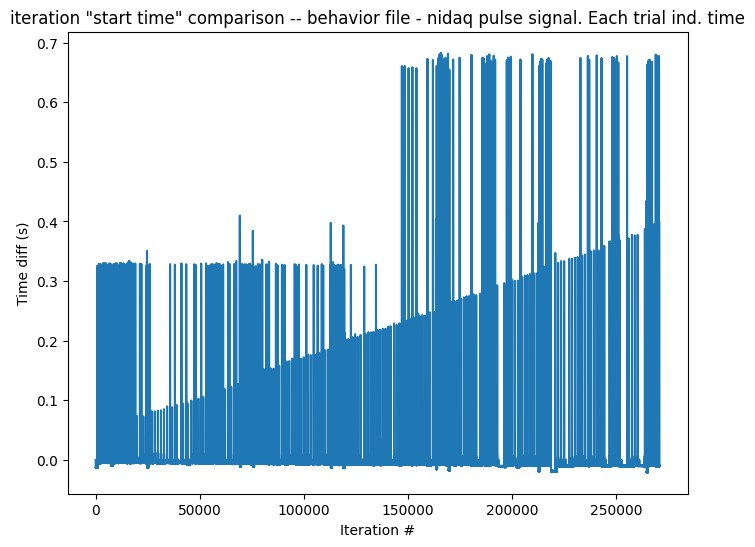

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(diff_time_trial_ind)

plt.xlabel('Iteration #')
plt.ylabel('Time diff (s)')
plt.title('iteration "start time" comparison -- behavior file - nidaq pulse signal. Each trial ind. time')



In [52]:
diff_time_trial_ind.argmin()

np.int64(265144)

In [53]:
behavior_time[0].keys()

dict_keys(['subject_fullname', 'session_date', 'session_number', 'iteration_matrix', 'trial_time', 'cumulative_session_time', 'collision', 'position', 'velocity', 'sensor_dots'])

In [54]:
behavior_time[0]['iteration_matrix'].shape

(270889, 3)

In [55]:
consecutive_trials = behavior_time[0]['iteration_matrix'][:,1].copy()
print('consecutive_trials', consecutive_trials.shape)
blocks_session = np.unique(behavior_time[0]['iteration_matrix'][:,0])
for i in range(blocks_session.shape[0]-1):
#for i in range(3):

    this_block = blocks_session[i]

    indices = np.argwhere(behavior_time[0]['iteration_matrix'][:,0] == this_block)

    print('this_block', this_block)

    last_index = indices[-1][0] # Access the last element and extract the index

    print('last_index', last_index)
    print('consecutive_trials[last_index]', consecutive_trials[last_index])
    consecutive_trials[last_index+1:] += behavior_time[0]['iteration_matrix'][last_index,1]

consecutive_trials (270889,)
this_block 1.0
last_index 7318
consecutive_trials[last_index] 10.0
this_block 2.0
last_index 24661
consecutive_trials[last_index] 30.0
this_block 3.0
last_index 69274
consecutive_trials[last_index] 70.0
this_block 4.0
last_index 75529
consecutive_trials[last_index] 80.0
this_block 5.0
last_index 112977
consecutive_trials[last_index] 120.0
this_block 6.0
last_index 119018
consecutive_trials[last_index] 130.0
this_block 7.0
last_index 163524
consecutive_trials[last_index] 170.0
this_block 8.0
last_index 169532
consecutive_trials[last_index] 180.0
this_block 9.0
last_index 212696
consecutive_trials[last_index] 220.0
this_block 10.0
last_index 218823
consecutive_trials[last_index] 230.0
this_block 11.0
last_index 264754
consecutive_trials[last_index] 262.0


In [56]:
consecutive_trials.max()

np.float64(272.0)

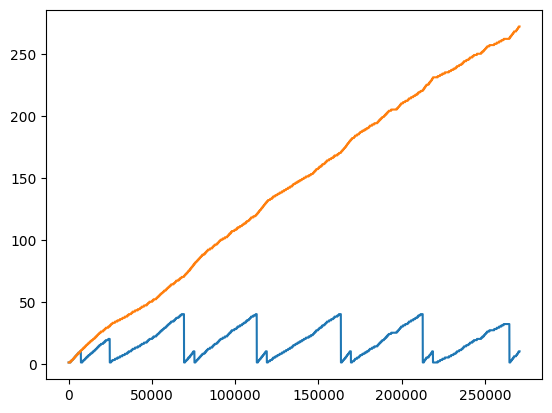

In [57]:
plt.plot(behavior_time[0]['iteration_matrix'][:,1])
plt.plot(consecutive_trials)

In [58]:
print(behavior_time[0]['iteration_matrix'][diff_time_trial_ind.argmin(),0])
print(behavior_time[0]['iteration_matrix'][diff_time_trial_ind.argmin(),1])
print(behavior_time[0]['iteration_matrix'][diff_time_trial_ind.argmin(),2])
print(consecutive_trials[diff_time_trial_ind.argmin()])

12.0
1.0
390.0
263.0


In [59]:
diff_time_trial_ind[-5:]

array([-0.01086269, -0.01093176, -0.01090668, -0.01106539, -0.01109345])

#### "pulse only sync" Each trial individual time [0, ...] x ntrials 
#### Historgram nidaq signal for behavior iteration "start time".

Text(0.5, 1.0, 'iteration "start time" Histogram -- behavior file - nidaq pulse signal. Each trial ind. time')

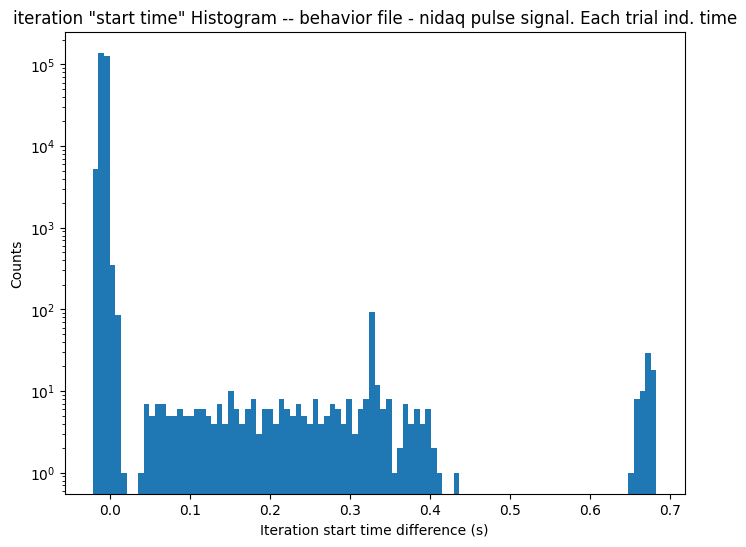

In [60]:
plt.figure(figsize=(8, 6))

plt.hist(diff_time_trial_ind,bins=100)

plt.yscale('log')
plt.xlabel('Iteration start time difference (s)')
plt.ylabel('Counts')
plt.title('iteration "start time" Histogram -- behavior file - nidaq pulse signal. Each trial ind. time')



#### Sanity check "virmen assisted sync" Each trial individual time [0, ...] x ntrials 
#### Compare  iteration "start time" --- nidaq pulse signal vs behavior file

In [61]:
print(diff_time_trial_ind_v.max())
print(diff_time_trial_ind_v.min())

2.803462848532945e-07
-0.0002002232267841464


#### "pulse only sync" single vector time for all session [0, ...] x 1
#### Compare nidaq signal for behavior iteration "start time".

Text(0.5, 1.0, 'iteration "start time" comparison -- behavior file - nidaq pulse signal. Single vector time all session')

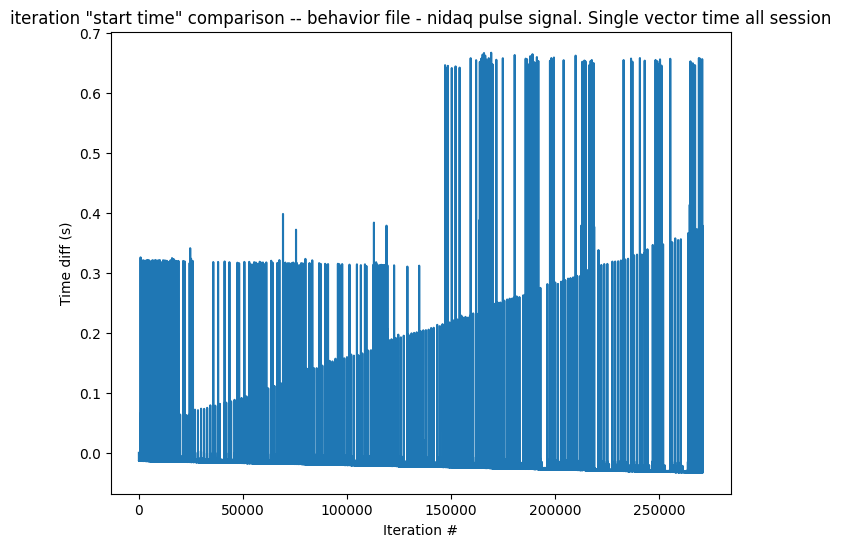

In [62]:
plt.figure(figsize=(8, 6))
plt.plot(diff_time_trial_full_session)

plt.xlabel('Iteration #')
plt.ylabel('Time diff (s)')
plt.title('iteration "start time" comparison -- behavior file - nidaq pulse signal. Single vector time all session')

Text(0.5, 1.0, 'iteration "start time" Histogram -- behavior file - nidaq pulse signal. Single vector time all session')

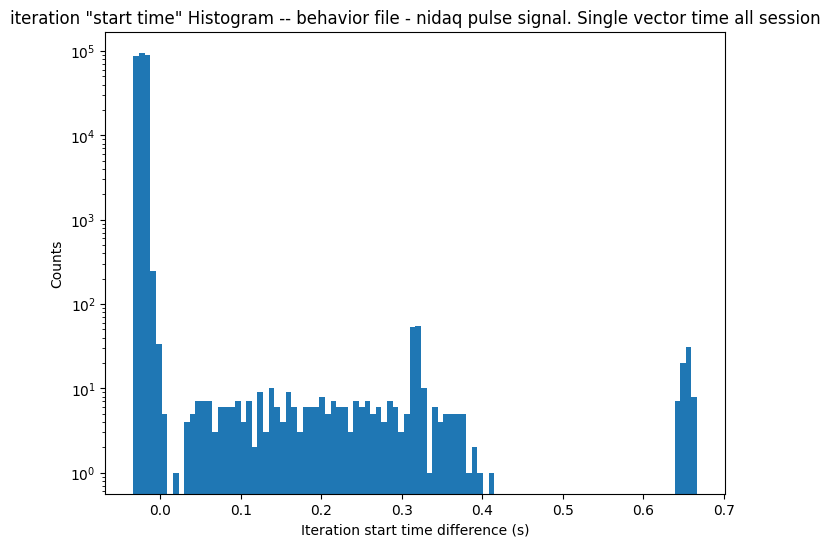

In [68]:
plt.figure(figsize=(8, 6))

abs_diff_time_trial_full_session = np.abs(diff_time_trial_full_session)

plt.hist(diff_time_trial_full_session,bins=100)

plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Iteration start time difference (s)')
plt.ylabel('Counts')
plt.title('iteration "start time" Histogram -- behavior file - nidaq pulse signal. Single vector time all session')



#### Sanity check "virmen assisted sync" Single vector time all session
#### Compare  iteration "start time" --- nidaq pulse signal vs behavior file

Text(0.5, 1.0, 'iteration "start time" sanity check comparison -- behavior file - nidaq pulse signal. Single vector time all session')

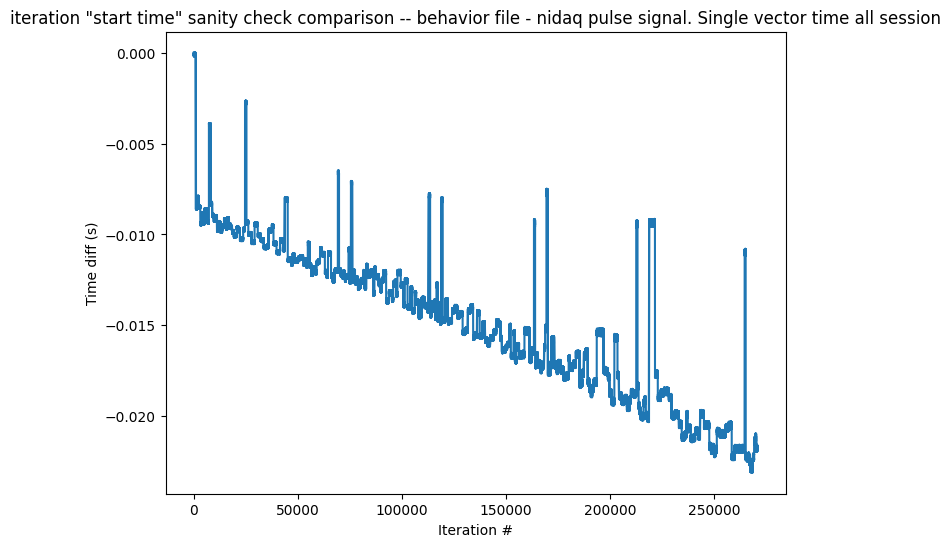

In [69]:


plt.figure(figsize=(8, 6))
plt.plot(diff_time_trial_full_session_v)

plt.xlabel('Iteration #')
plt.ylabel('Time diff (s)')
plt.title('iteration "start time" sanity check comparison -- behavior file - nidaq pulse signal. Single vector time all session')



#### "pulse only sync" vs "virmen assisted sync" comparison

In [70]:
diff_times_fullsessions = time_as_behavior_fullsession_v - time_as_behavior_fullsession
diff_times_trial_inds = time_as_behavior_trial_ind_v - time_as_behavior_trial_ind

#### "pulse only sync" vs "virmen assisted sync" comparison
#### single vector time for all session [0, ...] x 1

Text(0.5, 1.0, 'iteration "start time" comparison -- "pulse only sync" vs "virmen assisted sync" single vector time for all session [0, ...] x 1')

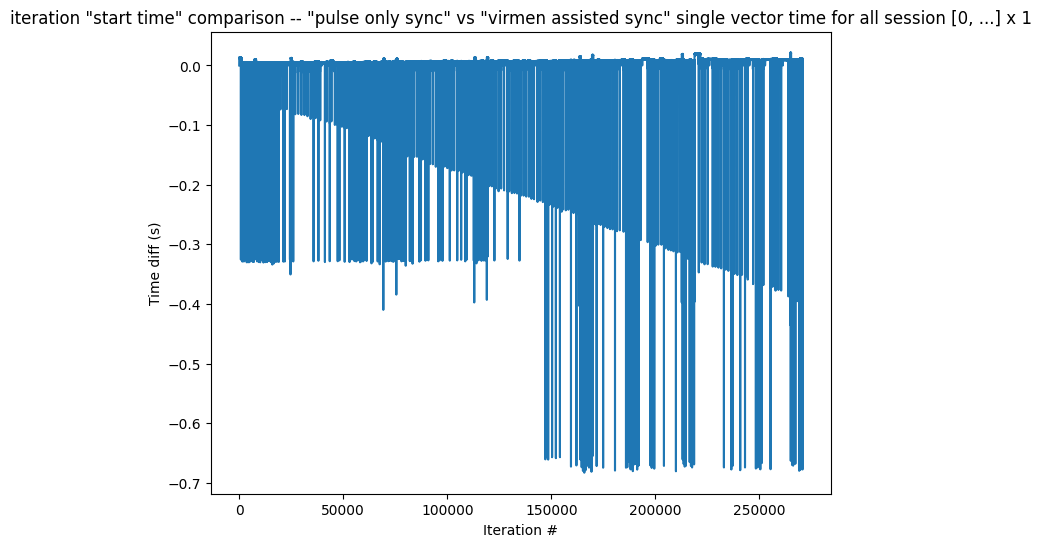

In [71]:


plt.figure(figsize=(8, 6))
plt.plot(diff_times_fullsessions)

plt.xlabel('Iteration #')
plt.ylabel('Time diff (s)')
plt.title('iteration "start time" comparison -- "pulse only sync" vs "virmen assisted sync" single vector time for all session [0, ...] x 1')



Text(0.5, 1.0, 'iteration "start time" histogram  -- "pulse only sync" vs "virmen assisted sync" single vector time for all session [0, ...] x 1')

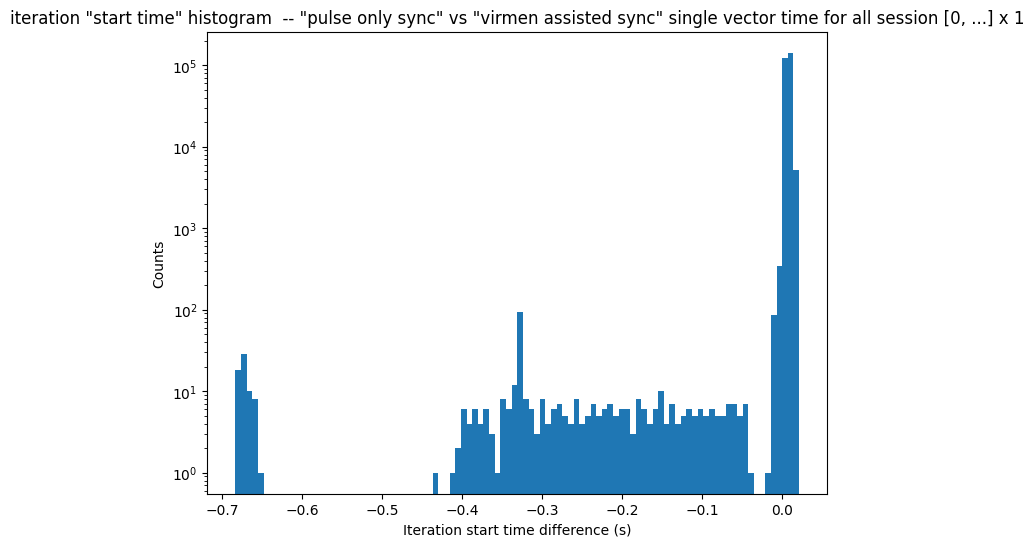

In [72]:
plt.figure(figsize=(8, 6))

plt.hist(diff_times_fullsessions,bins=100)

plt.yscale('log')
plt.xlabel('Iteration start time difference (s)')
plt.ylabel('Counts')
plt.title('iteration "start time" histogram  -- "pulse only sync" vs "virmen assisted sync" single vector time for all session [0, ...] x 1')


#### No difference in diff between trial individual and full session "pulse only sync" vs "virmen assisted sync"

In [65]:
(diff_times_fullsessions - diff_times_trial_inds).max()

np.float64(3.552713678800501e-15)